# Qiskit Scratch Work
This notebook contains scratch work from learning how to IMB's quantum Qiskit package.

In [15]:
from dotenv import load_dotenv
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Estimator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorOptions, EstimatorV2, QiskitRuntimeService
from rustworkx.visualization import mpl_draw as draw_graph
import matplotlib.pyplot as plt
import numpy as np
import os
import qiskit
import rustworkx as rx

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")

## Install Qiskit
This section follows the installation section from the [IBM Quantum Documentation](https://docs.quantum.ibm.com/guides/install-qiskit).

In [2]:
qiskit.__version__

'1.3.1'

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", token=API_TOKEN)

"""AccountAlreadyExistsError: 'Named account (default-ibm-quantum) already exists. Set overwrite=True to overwrite.'"""
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_TOKEN) 

backend = service.backend(name="ibm_brisbane")

In [4]:
backend.num_qubits

127

## Create your first quantum program in Qiskit
This section follows the `README.md` from the [GitHub repo](https://github.com/Qiskit/qiskit).

In [5]:
# 1. A quantum circuit for preparing the quantum state |000> + i |111>
qc_example = QuantumCircuit(3)
qc_example.h(0)          # generate superpostion
qc_example.p(np.pi/2,0)  # add quantum phase
qc_example.cx(0,1)       # 0th-qubit-Controlled-NOT gate on 1st qubit
qc_example.cx(0,2)       # 0th-qubit-Controlled-NOT gate on 2nd qubit

# 2. Add the classical output in the form of measurement of all qubits
qc_measured = qc_example.measure_all(inplace=False)

# 3. Execute using the Sampler primitive
sampler = StatevectorSampler()
job = sampler.run([qc_measured], shots=1000)
result = job.result()
print(f" > Counts: {result[0].data['meas'].get_counts()}")

# 2. Define the observable to be measured
operator = SparsePauliOp.from_list([("XXY", 1), ("XYX", 1), ("YXX", 1), ("YYY", -1)])

# 3. Execute using the Estimator primitive
estimator = StatevectorEstimator()
job = estimator.run([(qc_example, operator)], precision=1e-3)
result = job.result()
print(f" > Expectation values: {result[0].data.evs}")

qc_transpiled = transpile(qc_example, basis_gates = ['cz', 'sx', 'rz'], coupling_map =[[0, 1], [1, 2]] , optimization_level=3)

 > Counts: {'000': 496, '111': 504}
 > Expectation values: 4.0020364602296175


## Hello World
This section follows the [Hello World](https://docs.quantum.ibm.com/guides/hello-world) section of the IBM quantum documentation.

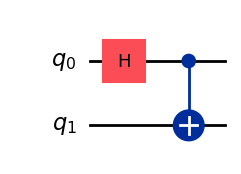

In [6]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output='mpl')

In [7]:
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')
observables = [ZZ, ZI, IZ, XX, XI, IX]
estimator = Estimator()
job = estimator.run([qc] * len(observables), observables)
job.result()

EstimatorResult(values=array([ 1.        , -0.0234375 , -0.0234375 ,  1.        , -0.02929688,
       -0.02929688]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'time_taken': 0.0096557, 'num_bind_params': 1, 'parallel_state_update': 4, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000866, 'active_input_qubits': [0, 1], 'num_clbits': 2, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 7886, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.99945068359375, 'simulator_metadata': [{'time_taken': 0.0096557, 'num_bind_params': 1, 'parallel_state_update': 4, 'parallel_shots': 1, 'required_memory_mb': 0, 'input_qubit_map': [[1, 1], [0, 0]], 'method': 'stabilizer', 'device': 'CPU', 'num_qubits': 2, 'sample_measure_time': 0.000866, 'act

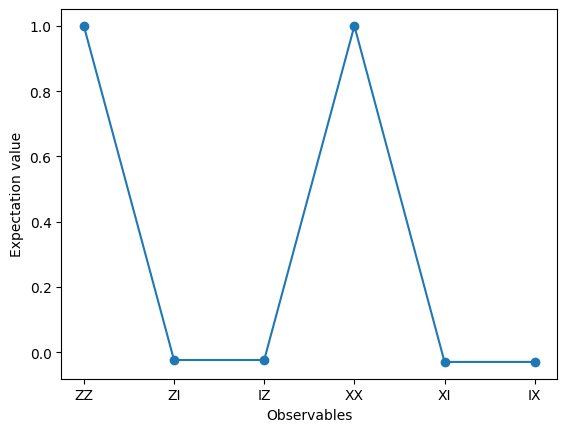

In [8]:
data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values
plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

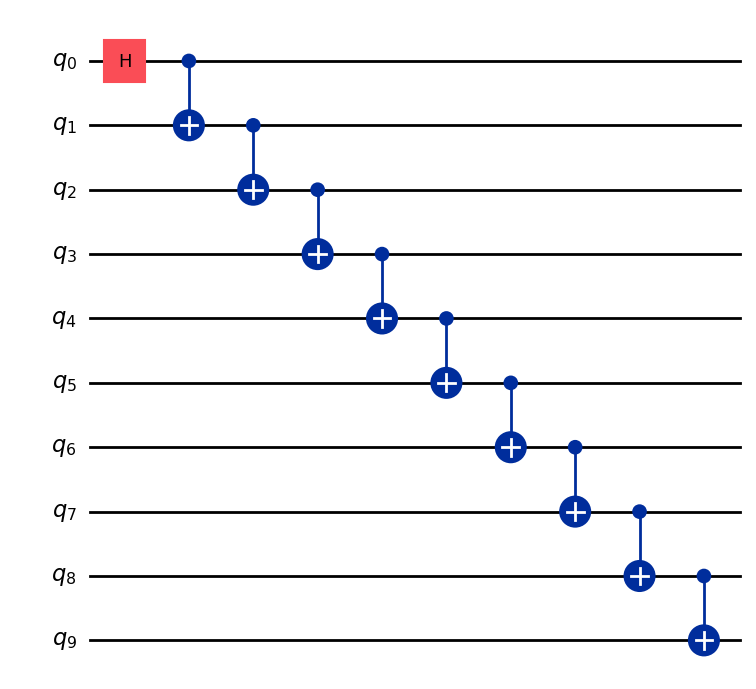

In [9]:
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1):
        qc.cx(i, i+1)
    return qc


n = 10#0
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output='mpl')

In [10]:
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range (n-1)]
print(operator_strings)
print(len(operator_strings))
operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

['ZZIIIIIIII', 'ZIZIIIIIII', 'ZIIZIIIIII', 'ZIIIZIIIII', 'ZIIIIZIIII', 'ZIIIIIZIII', 'ZIIIIIIZII', 'ZIIIIIIIZI', 'ZIIIIIIIIZ']
9


In [11]:
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

```py
options = EstimatorOptions()
options.resilience_level = 1
# options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"
estimator = EstimatorV2(backend, options=options)
job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)
```

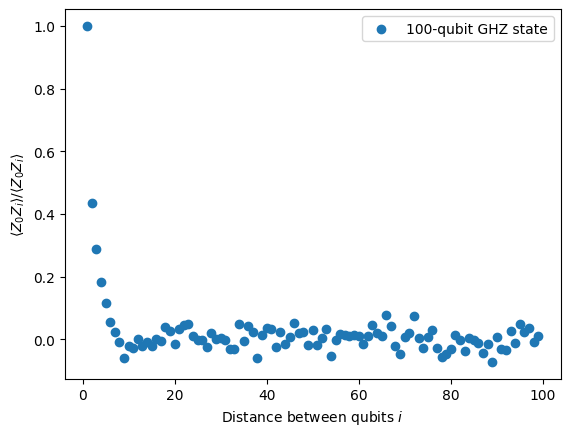

In [12]:
n = 100
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range (n-1)]
operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

job_id = 'cy0ys7cnrmz000853zag'
job = service.job(job_id)
data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v/values[0] for v in values]
plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_i \rangle$')
plt.legend()
plt.show()

## Solve utility-scale quantum optimization problems
This section follows the "[Solve utility-scale quantum optimization problems](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm)" section of the IBM Quantum Learning tutorial.

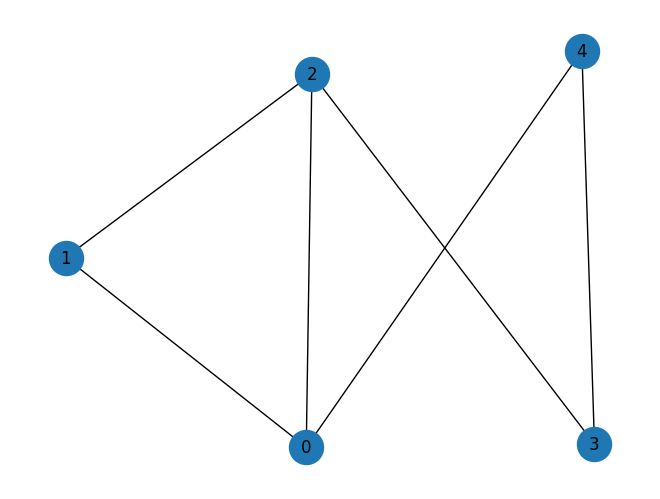

In [13]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [14]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


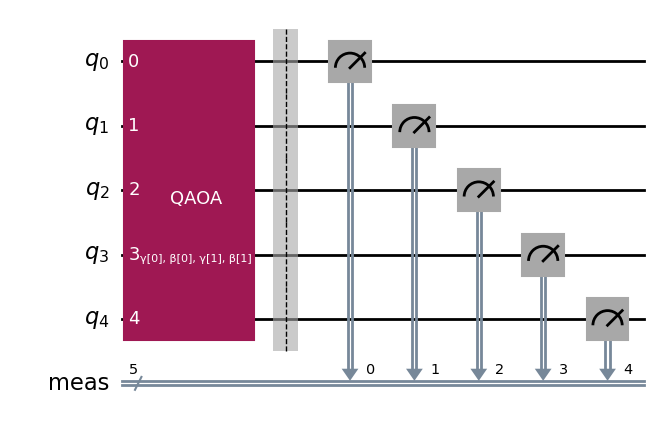

In [16]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [17]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])